In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import numpy as np
import torchvision
import torch
import torch.optim as optim
from torch import nn


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((32, 32))
    ])

batch_size = 4

TRAIN_PATH = '/content/gdrive/MyDrive/tiny-image-subset/train/'
TEST_PATH = '/content/gdrive/MyDrive/tiny-image-subset/val/'

#train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
#ImageFolder(root=TRAIN_PATH, transform=transform)

trainset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('fish', 'lizard', 'frog', 'frog2',
           'crocodile', 'snake', 'insects', 'spider', 'cat', 'shoemaker')

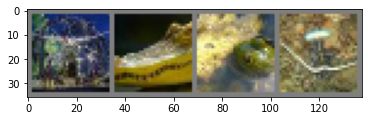

spider crocodile frog  spider


In [3]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import ProtoNetBack
net = ProtoNetBack.ProtoNetBack(3)

print(net)

ProtoNetBack(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [5]:
def plot(train_accu, train_losses):
  
  plt.plot(train_accu)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Train Accuracy')
  plt.show()

  plt.plot(train_losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Train Loss')
  plt.show()

In [6]:
def test(net, testloader):

  correct = 0
  total = 0
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  net.to(device)

  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 500 test images: %d %%' % (
      100 * correct / total))


  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_accu = []
train_losses = []

for epoch in range(10):

    running_loss = 0.
    correct=0
    total=0
    batch_size = 100
      
    for i, data in enumerate(
              torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2), 0):
          
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
          
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss=running_loss/len(trainloader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(loss.item())
          
        print('[%d, %5d] loss: %.4f accuracy: %.2f' %(epoch + 1, (i+1)*batch_size, loss.item(), accu))

print('Finished Training')

torch.save(net, '1.pkl')

[1,   100] loss: 2.3020 accuracy: 14.00
[1,   200] loss: 2.3202 accuracy: 13.00
[1,   300] loss: 2.2263 accuracy: 16.33
[1,   400] loss: 2.1648 accuracy: 17.75
[1,   500] loss: 2.0843 accuracy: 20.80
[1,   600] loss: 2.1876 accuracy: 21.67
[1,   700] loss: 2.1041 accuracy: 22.71
[1,   800] loss: 2.2186 accuracy: 22.62
[1,   900] loss: 2.0815 accuracy: 23.00
[1,  1000] loss: 2.1454 accuracy: 22.70
[1,  1100] loss: 2.0445 accuracy: 23.45
[1,  1200] loss: 2.0684 accuracy: 23.83
[1,  1300] loss: 1.9469 accuracy: 24.85
[1,  1400] loss: 1.9332 accuracy: 25.57
[1,  1500] loss: 1.9386 accuracy: 25.93
[1,  1600] loss: 1.8834 accuracy: 26.31
[1,  1700] loss: 1.7781 accuracy: 27.12
[1,  1800] loss: 1.7758 accuracy: 28.17
[1,  1900] loss: 1.7450 accuracy: 28.89
[1,  2000] loss: 1.8159 accuracy: 29.35
[1,  2100] loss: 1.8442 accuracy: 29.81
[1,  2200] loss: 1.7606 accuracy: 30.27
[1,  2300] loss: 1.5769 accuracy: 31.17
[1,  2400] loss: 1.7435 accuracy: 31.67
[1,  2500] loss: 1.7674 accuracy: 31.76


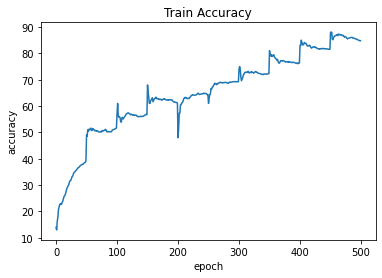

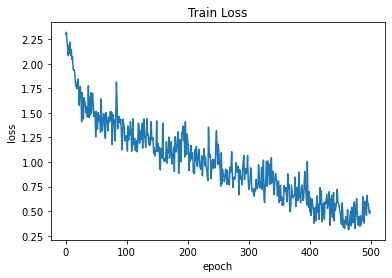

Accuracy of the network on the 500 test images: 22 %
Accuracy of  fish : 16 %
Accuracy of lizard : 18 %
Accuracy of  frog :  8 %
Accuracy of frog2 : 30 %
Accuracy of crocodile : 14 %
Accuracy of snake : 12 %
Accuracy of insects : 26 %
Accuracy of spider : 34 %
Accuracy of   cat : 22 %
Accuracy of shoemaker : 48 %


In [8]:
plot(train_accu, train_losses)
test(net, testloader)

In [13]:
model = torch.load('cifar10.pkl')
params = model.state_dict()
keys = list(params.keys())
keys = keys[:len(keys)-4]
#print(keys)

cnt = 1 
for param in model.parameters():
    param.requires_grad = False
    if cnt == 18 :
      break
    cnt += 1

for name, param in model.named_parameters():
  if param.requires_grad:print(name)

FC1.weight
FC1.bias
FC2.weight
FC2.bias


In [16]:
model = torch.load('cifar10.pkl')
params = model.state_dict()
keys = list(params.keys())
keys = keys[:len(keys)-4]
#print(keys)

cnt = 1 
for param in model.parameters():
    param.requires_grad = False
    if cnt == 18 :
      break
    cnt += 1

for name, param in model.named_parameters():
  if param.requires_grad:print(name)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accu = []
train_losses = []

for epoch in range(10):

    running_loss = 0.
    correct=0
    total=0
    batch_size = 100
      
    for i, data in enumerate(
              torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2), 0):
          
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
          
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss=running_loss/len(trainloader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(loss.item())
          
        print('[%d, %5d] loss: %.4f accuracy: %.2f' %(epoch + 1, (i+1)*batch_size, loss.item(), accu))

print('Finished Training')

torch.save(model, '2.pkl')

FC1.weight
FC1.bias
FC2.weight
FC2.bias
[1,   100] loss: 7.2661 accuracy: 16.00
[1,   200] loss: 6.5408 accuracy: 18.50
[1,   300] loss: 6.3327 accuracy: 15.00
[1,   400] loss: 5.6476 accuracy: 13.50
[1,   500] loss: 5.0978 accuracy: 13.00
[1,   600] loss: 4.9242 accuracy: 12.00
[1,   700] loss: 4.6934 accuracy: 12.14
[1,   800] loss: 5.0234 accuracy: 11.88
[1,   900] loss: 4.3243 accuracy: 11.78
[1,  1000] loss: 4.2801 accuracy: 11.70
[1,  1100] loss: 4.0044 accuracy: 11.73
[1,  1200] loss: 3.5873 accuracy: 11.83
[1,  1300] loss: 2.8663 accuracy: 12.23
[1,  1400] loss: 3.1308 accuracy: 12.43
[1,  1500] loss: 2.9587 accuracy: 12.40
[1,  1600] loss: 2.9718 accuracy: 12.50
[1,  1700] loss: 2.8633 accuracy: 12.24
[1,  1800] loss: 2.7985 accuracy: 12.06
[1,  1900] loss: 2.4189 accuracy: 12.63
[1,  2000] loss: 2.6162 accuracy: 12.50
[1,  2100] loss: 2.5027 accuracy: 12.43
[1,  2200] loss: 2.4240 accuracy: 12.50
[1,  2300] loss: 2.2966 accuracy: 12.70
[1,  2400] loss: 2.2517 accuracy: 12.88


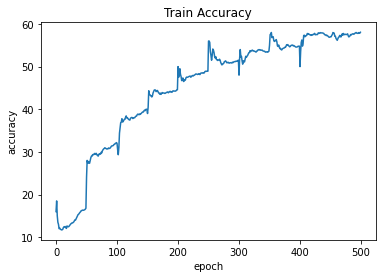

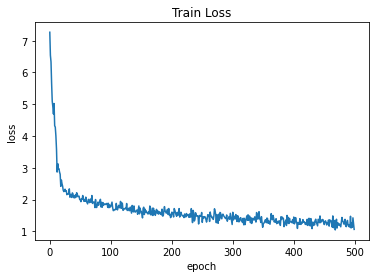

Accuracy of the network on the 500 test images: 23 %
Accuracy of  fish : 12 %
Accuracy of lizard : 18 %
Accuracy of  frog : 32 %
Accuracy of frog2 : 18 %
Accuracy of crocodile : 24 %
Accuracy of snake : 22 %
Accuracy of insects : 20 %
Accuracy of spider : 34 %
Accuracy of   cat : 24 %
Accuracy of shoemaker : 34 %


In [17]:
plot(train_accu, train_losses)
test(model, testloader)

In [18]:
model = torch.load('cifar10.pkl')

for name, param in model.named_parameters():
  if param.requires_grad:print(name)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accu = []
train_losses = []

for epoch in range(10):

    running_loss = 0.
    correct=0
    total=0
    batch_size = 100
      
    for i, data in enumerate(
              torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2), 0):
          
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
          
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss=running_loss/len(trainloader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(loss.item())
          
        print('[%d, %5d] loss: %.4f accuracy: %.2f' %(epoch + 1, (i+1)*batch_size, loss.item(), accu))

print('Finished Training')

torch.save(model, '3.pkl')

layers.0.weight
layers.0.bias
layers.1.0.weight
layers.1.0.bias
layers.1.1.weight
layers.1.1.bias
layers.2.0.weight
layers.2.0.bias
layers.2.1.weight
layers.2.1.bias
layers.3.0.weight
layers.3.0.bias
layers.3.1.weight
layers.3.1.bias
layers.4.0.weight
layers.4.0.bias
layers.4.1.weight
layers.4.1.bias
FC1.weight
FC1.bias
FC2.weight
FC2.bias
[1,   100] loss: 7.9721 accuracy: 11.00
[1,   200] loss: 6.1130 accuracy: 13.50
[1,   300] loss: 6.1099 accuracy: 12.33
[1,   400] loss: 4.5829 accuracy: 15.50
[1,   500] loss: 4.4353 accuracy: 16.00
[1,   600] loss: 4.4392 accuracy: 17.00
[1,   700] loss: 3.5105 accuracy: 18.00
[1,   800] loss: 3.2649 accuracy: 19.50
[1,   900] loss: 3.1276 accuracy: 20.56
[1,  1000] loss: 2.6144 accuracy: 21.70
[1,  1100] loss: 3.0202 accuracy: 22.00
[1,  1200] loss: 2.6262 accuracy: 22.83
[1,  1300] loss: 2.4990 accuracy: 23.15
[1,  1400] loss: 2.2132 accuracy: 23.86
[1,  1500] loss: 2.2170 accuracy: 24.33
[1,  1600] loss: 2.1828 accuracy: 24.62
[1,  1700] loss: 2

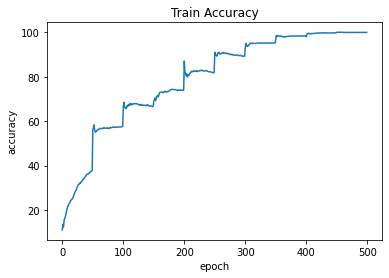

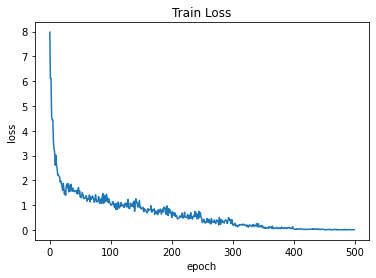

Accuracy of the network on the 500 test images: 24 %
Accuracy of  fish : 26 %
Accuracy of lizard : 26 %
Accuracy of  frog : 22 %
Accuracy of frog2 : 28 %
Accuracy of crocodile : 20 %
Accuracy of snake : 18 %
Accuracy of insects : 26 %
Accuracy of spider : 28 %
Accuracy of   cat : 12 %
Accuracy of shoemaker : 42 %


In [19]:
plot(train_accu, train_losses)
test(model, testloader)